# WM811k Silicon Wafer Map Dataset Image

WM811k Silicon Wafer Map Dataset with Defect Detection

Dataset on => [Kaggle](https://www.kaggle.com/datasets/muhammedjunayed/wm811k-silicon-wafer-map-dataset-image/data)

---
<p>
<b>TABLE OF CONTENTS</b>
    
    1. Setup
    2. Data Preprocessing
    3. Defining Convolutional Neural Network
    4. Pipeline
    5. Rerun *Stage 3* & (SWA), Fine-tuning
    6. Summary


## Import & Device check

In [1]:
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from torch.utils.data import DataLoader, random_split
from torchvision import models, datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")

print(f"Selected Device: {device}")

Selected Device: mps


## Learning Rate Finder

<span style="color:yellow">only use after `configure_stage` is in memory</span>

In [ ]:
def find_base_lr():
    # 1) Coonfiguring Stage 1 (only head+fc unfrozen)
    configure_stage(1)

    # 2) Extracting clean copy of the param‐groups (strip out scheduler state)
    fresh_groups = [
        {"params": pg["params"], "lr": pg["lr"]}
        for pg in optimizer.param_groups
    ]

    # 3) Build brand-new optimizer with exactly those groups, no scheduler
    fresh_opt = torch.optim.Adam(fresh_groups, weight_decay=4e-4)

    # 4) hand-over to LR-finder
    lr_finder = LRFinder(model, fresh_opt, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
    lr_finder.plot()     # inspect loss vs LR
    lr_finder.reset()    # back to starting weights & optimizer

In [ ]:
find_base_lr()

## Model Selection

Select architecture (freeze as base) from `torchvision.models` like
- `.resnet50(pretrained=True)`
- `.resnet101(pretrained=True)`
- `.resnet152(pretrained=True)`

In [2]:
model = models.resnet152(pretrained=True)

NUM_CLASSES = len(os.listdir("data/WM811k_Dataset"))
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.to(device)
os.makedirs("checkpoints", exist_ok=True)
torch.save(model.state_dict(), "checkpoints/wafer_cnn_pretrained_backbone.pt")

/opt/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Hyperparams

In [3]:
BATCH_SIZE      = 32
LR              = 1e-4
NUM_EPOCHS      = 50
IMG_SIZE        = 128
DATA_ROOT       = "data/WM811k_Dataset"
CHECKPOINT_ROOT = "checkpoints"

os.makedirs(CHECKPOINT_ROOT, exist_ok=True)

## Data Preview

<span style="color:yellow">One random sample per class.</span>

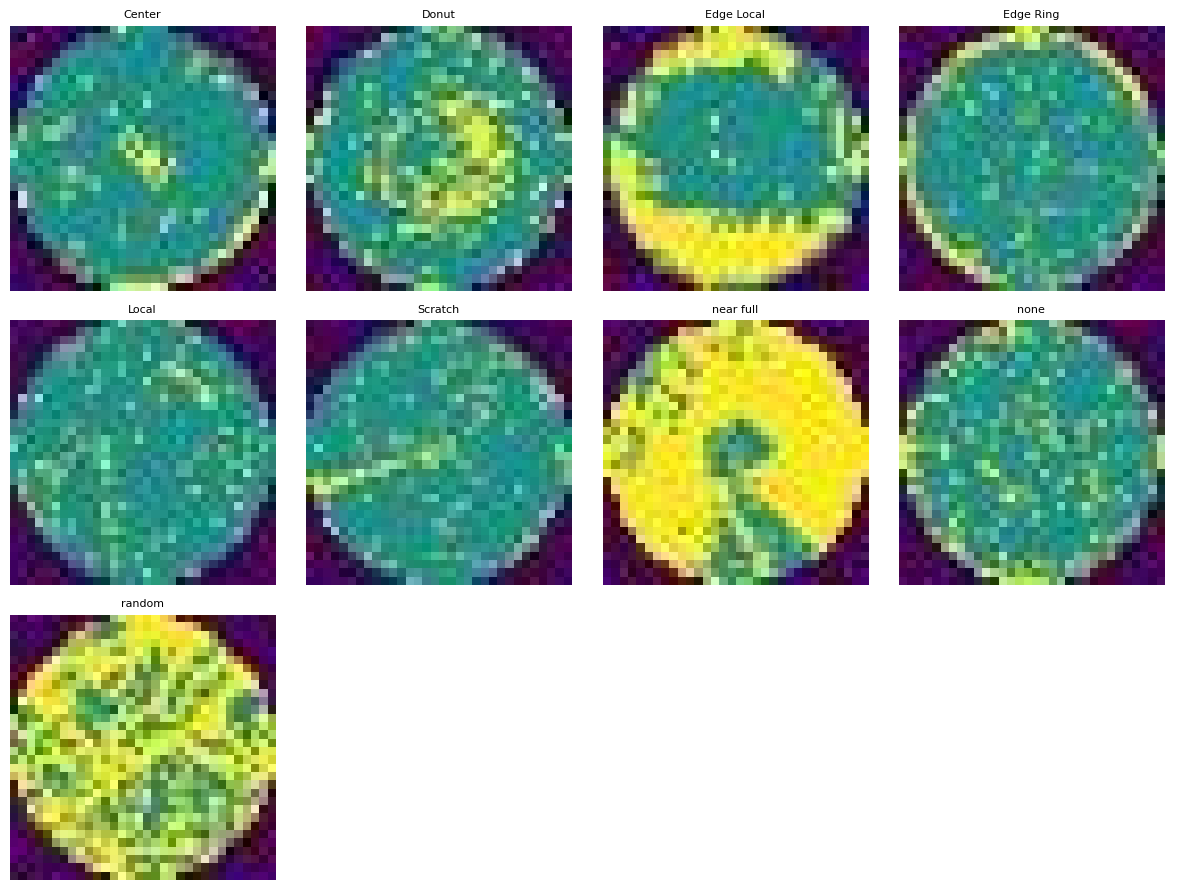

In [4]:
root_dir = DATA_ROOT
classes = sorted(d for d in os.listdir(root_dir)
                 if os.path.isdir(os.path.join(root_dir, d)))

samples = []
for cls in classes:
    cls_dir = os.path.join(root_dir, cls)
    imgs = [f for f in os.listdir(cls_dir)
            if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if not imgs: continue
    img_path = os.path.join(cls_dir, random.choice(imgs))
    samples.append((cls, img_path))

n = len(samples)
cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
axes = axes.flatten()
for ax, (cls, path) in zip(axes, samples):
    img = Image.open(path)
    ax.imshow(img)
    ax.set_title(cls, fontsize=8)
    ax.axis('off')
for ax in axes[len(samples):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

## DataLoaders

- `tfm = transforms.Compose([...])` builds a chain of image transforms that will be applied to every sample.
- `full_ds = datasets.ImageFolder(DATA_ROOT, transform=tfm)` wraps all images (organized in subfolders by class) into a single dataset that applies those transforms
- `train_ds, val_ds = random_split(full_ds, [...])` splits dataset into 80/20 (train/validation) subsets
- `DataLoader(...)` from `torch.utils.data` creates iterators over the train and validation subsets

Outcome:
- `train_loader` and `val_loader` will yield augmented, normalized batches ready for the model

In [5]:
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.RandomHorizontalFlip(),      
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.10)),
    
    transforms.ToTensor(),
    transforms.Normalize([.485,.456,.406],[.229,.224,.225]),
])
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(
        p=0.25, scale=(0.02, 0.10), ratio=(0.3, 3.3), value='random'
    ),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


full_ds = datasets.ImageFolder(DATA_ROOT, transform=tfm)
n = len(full_ds)
train_ds, val_ds = random_split(full_ds, [int(0.8*n), n - int(0.8*n)])

pin = True if device.type == "cuda" else False

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=pin
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=pin
)

## Loss function & `configure_stage`

1) **Loss function**
- Equations and details on *CrossEntropyLoss* are explained here: [official PyTorch documentation](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).


2) **Helper function** (`configure_stage`)
- `configure_stage` is helper function to set up each fine-tuning *stage* (see below)#
- Core elements of helper function:
  - <span style="color:magenta">Freeze/Unfreeze</span>
    - Stage 1: only training of classifier head (layer4+fc);
    - Stage 2: unfreezing of layer3;
    - Stage 3: unfreezing of all layers; BatchNorm layers are put into eval mode (freezing their running stats);
  - <span style="color:magenta">Parameter groups & learning rates (LR)</span>
    - Building `optimizer` groups with different LRs for head, mid, and earlier layers, scaled by the `head_mult`, `layer3_mult`, etc.;
    - Picking a list of `max_lr` values for OneCycle scheduling;
  - <span style="color:magenta">Optimizer & Schedulers</span>
    - Creates an Adam optimizer with weight decay;
    - Wraps it in a OneCycleLR scheduler (with % warm-up, `div_factor` initial slope, `final_div_factor` tail);
    - Wraps the model in a *Stochastic Weight Averaging* (SWA) wrapper (`swa_model`) and an SWA LR scheduler (`swa_scheduler`), for starting averaging later:
      - instead of taking the final model’s weights at the end of training, a running average of the weights over multiple points (typically late in training) is maintained and that averaged model is used at test time. It tends to sit in wider, flatter regions of the loss landscape and gives better generalization.

In [6]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

def configure_stage(stage:int,
                    pct_start=None,
                    div_factor=None,
                    final_div_factor=None,
                    layer2_mult=None,
                    layer3_mult=None,
                    head_mult=None,
                    swa_frac=None):
    global optimizer, scheduler, swa_model, swa_scheduler

    # 1) freeze/unfreeze
    for name, p in model.named_parameters():
        if stage == 1:
            p.requires_grad = name.startswith(("layer4","fc"))
        elif stage == 2:
            p.requires_grad = name.startswith(("layer3","layer4","fc"))
        else:
            p.requires_grad = True

    # 2) param‐groups + max_lr
    if stage == 1:
        hm = head_mult or 2.0
        head = list(model.layer4.parameters()) + list(model.fc.parameters())
        groups, max_lr = [{"params": head, "lr": LR*hm}], [LR*hm]

    elif stage == 2:
        hm = head_mult or 1.75
        mm = layer3_mult or 1.05
        head = list(model.layer4.parameters()) + list(model.fc.parameters())
        mid  = list(model.layer3.parameters())
        groups = [
            {"params": head, "lr": LR*hm},
            {"params": mid,  "lr": LR*mm},
        ]
        max_lr = [LR*hm, LR*mm]

    else:
        l2 = layer2_mult or 0.3
        l3 = layer3_mult or 0.6
        hm = head_mult or 2.5
        groups = [
            {"params": model.layer1.parameters(),"lr":LR*0.1},
            {"params": model.layer2.parameters(),"lr":LR*l2},
            {"params": model.layer3.parameters(),"lr":LR*l3},
            {"params": model.layer4.parameters(),"lr":LR*1.0},
            {"params": model.fc.parameters(),"lr":LR*hm},
        ]
        max_lr = [LR*x for x in (0.1, l2, l3, 1.0, hm)]
        # freezes running stats in BN
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d): m.eval()

    # 3) optimizer + OneCycle + SWA
    optimizer = optim.Adam(groups, weight_decay=4e-4)
    ps = pct_start or 0.35
    df = div_factor or 10
    fdf = final_div_factor or 8
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=NUM_EPOCHS,
        pct_start=ps,
        div_factor=df,
        final_div_factor=fdf,
        anneal_strategy='cos'
    )
    swa_model = AveragedModel(model)
    swa_scheduler = SWALR(
        optimizer,
        swa_lr=LR * (swa_frac or 0.2)
    )

    # 4) summary
    if stage == 1:
        print(f"→ Stage 1 configured (head×{hm:.2f})")
    elif stage == 2:
        print(f"→ Stage 2 configured (head×{hm:.2f}, mid×{mm:.2f}, "
              f"pct_start={ps:.2f}, div_factor={df}, final_df={fdf})")
    else:
        print(f"→ Stage 3 configured (l2×{l2:.2f}, l3×{l3:.2f}, head×{hm:.2f}, "
              f"pct_start={ps:.2f}, div_factor={df}, final_df={fdf}, swa_frac={swa_frac or 0.2:.2f})")

## `run_stage` helper with `model.train()` & `model.eval()`

`run_stage` is a helper function that encapsulates a full *stage* of training with one-cycle scheduling, early stopping, and *Stochastic Weight Averaging* (SWA).
<p></p>

**Basic Structure:**

1) <span style="color:magenta">Stage config</span>
2) <span style="color:magenta">Epoch loop</span>
   - Train (puts model in train mode, iterates over `train_loader`, computes cross-entropy, backpropagation, stepping the optimizer, advancing LR scheduler, tracking of last batch's loss (`trL`) and cumulative training accuracy (`trA`))
   - Validate (switches to eval mode, runs `val_loader` without gradients, accumulating total validation loss (`vL`) and accuracy (`vA`))
   - Logging & history
3) <span style="color:magenta">Early stopping & checkpointing</span>
   - If current `vL` is best, resets the early-stop counter and saves a “best” checkpoint
   - Otherwise increments a “stagnation” counter, and breaks out early, if it hits 10 epochs without improvement
4) <span style="color:magenta">Stochastic Weight Averaging</span>
   - After 75% of epochs, each epoch also updates the SWA model’s weights and its SWA LR scheduler
5) <span style="color:magenta">Final checkpoint save</span> (regardless of early stop) & <span style="color:magenta">return</span> of lists of train loss, train acc, val loss and val acc


In [7]:
def run_stage(stage: int, **cfg_overrides):
    configure_stage(stage, **cfg_overrides)
    EPOCH_SWA = int(NUM_EPOCHS * 0.75)
    best = float('inf')
    v_streak = 0
    tl = []
    vl = []
    ta = []
    va = []
    
    for ep in range(1, NUM_EPOCHS + 1):
        # ------- Training -------
        model.train()
        tot = 0
        cor = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = nn.CrossEntropyLoss(label_smoothing=0.1)(out,y)
            loss.backward()
            optimizer.step()
            preds = out.argmax(1)
            tot += y.size(0)
            cor += (preds == y).sum().item()
            scheduler.step()
        trL = loss.item()
        trA = cor/tot
        # ------- Validation -------
        model.eval()
        with torch.no_grad():
            tot = 0
            cor = 0
            vloss = 0
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device)
                out = model(x)
                vloss += nn.CrossEntropyLoss(label_smoothing=0.1)(out,y).item()*y.size(0)
                preds = out.argmax(1)
                tot += y.size(0)
                cor += (preds==y).sum().item()
            vL = vloss/tot
            vA = cor/tot
        # ------- Record & Print -------
        tl.append(trL)
        vl.append(vL)
        ta.append(trA)
        va.append(vA)
        lr = scheduler.get_last_lr()[0]
        print(f"S{stage} E{ep:02} | LR {lr:.4e}; Tr {trL:.3f} / {trA:.3f}; V {vL:.3f} / {vA:.3f}")

        # ------- Early‐stop & Checkpoint -------
        if vL < best:
            best, v_streak = vL, 0
            torch.save(model.state_dict(),f"{CHECKPOINT_ROOT}/wafer_cnn_stage{stage}.pt")
        else:
            v_streak += 1
            if v_streak >= 10:
                print(f"→ early stop triggered after {v_streak} stagnant epochs")
                break

        # ------- SWA step -------
        if ep >= EPOCH_SWA:
            swa_model.update_parameters(model)
            swa_scheduler.step()

    torch.save(model.state_dict(),f"{CHECKPOINT_ROOT}/wafer_cnn_stage{stage}_final.pt")
    return tl,vl,ta,va

## <span style="color:red">Stage 1</span>

### General briefing on params

1) **pct_start** (warm-up fraction)
   - Higher: spend more of the one-cycle schedule slowly ramping from low LR up to the peak (hence, model “warms in” more gently)
   - Lower: quicker ramp to peak LR, more time spent decaying; warms up fast but risks instability early.<p>
2) **div_factor** (initial LR divisor)
   - Higher: starting `LR = max_lr / div_factor` is smaller, so climbing up more slowly at first (safer but slower to learn)
   - Lower: starting closer to max_lr, hence, a sharper climb (faster initial learning, but may blow past the optimum)<p>
3) **final_div_factor** (final LR divisor)
   - Higher: your final `LR = max_lr / final_div_factor` is smaller, so the tail of the cycle decays to a very low LR (gentler “cool-down,” less drift)
   - Lower: final LR sits higher, hence, end with more aggressive steps (can adapt more late in training, but may destabilize)<p>
4) **head_mult** (LR multiplier on the new head)
   - Higher: the classifier layers (layer4 + fc) learn faster; good if they’re sorely undertrained, but risks overfitting or noisy updates
   - Lower: slows the head’s LR relative to the backbone—safer, if head is already close, but may be too timid to learn new classes<p>
5) **swa_frac** (SWA LR as a fraction of base LR)
   - Higher: SWA updates use a larger LR (more exploratory averaging, can converge faster to flatter minima but can oscillate)
   - Lower: smaller SWA LR (more conservative averaging, smoother but slower to incorporate new snapshots)

<p></p>

**In practice:**
    
 * bumping *pct_start* up if early unstable spikes,
 * raising *div_factor* for a gentler climb, if val-loss jumps,
 * tweaking *final_div_factor* to land at a sweet low LR at the end,
 * nudging *head_mult* up/down to let the head learn more or less aggressively,
 * adjusting *swa_frac* to control how strongly your SWA ensemble moves in late training.

### Stage 1 <span style="color:red">customized</span> run + plotting

/opt/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


→ Stage 1 configured (head×2.25)
S1 E01 | LR 2.1017e-05; Tr 2.012 / 0.230; V 2.072 / 0.343
S1 E02 | LR 2.7717e-05; Tr 1.829 / 0.447; V 1.783 / 0.547
S1 E03 | LR 3.8556e-05; Tr 1.628 / 0.595; V 1.540 / 0.608
S1 E04 | LR 5.3058e-05; Tr 1.392 / 0.637; V 1.346 / 0.652
S1 E05 | LR 7.0585e-05; Tr 1.382 / 0.709; V 1.213 / 0.707
S1 E06 | LR 9.0366e-05; Tr 1.015 / 0.768; V 1.167 / 0.751
S1 E07 | LR 1.1153e-04; Tr 0.976 / 0.809; V 1.076 / 0.762
S1 E08 | LR 1.3315e-04; Tr 1.123 / 0.845; V 1.102 / 0.735
S1 E09 | LR 1.5428e-04; Tr 0.808 / 0.856; V 1.293 / 0.724
S1 E10 | LR 1.7398e-04; Tr 1.261 / 0.867; V 1.095 / 0.746
S1 E11 | LR 1.9139e-04; Tr 0.970 / 0.897; V 1.138 / 0.746
S1 E12 | LR 2.0575e-04; Tr 1.018 / 0.871; V 1.141 / 0.740
S1 E13 | LR 2.1641e-04; Tr 0.812 / 0.890; V 1.064 / 0.768
S1 E14 | LR 2.2293e-04; Tr 0.689 / 0.929; V 1.092 / 0.751
S1 E15 | LR 2.2500e-04; Tr 0.935 / 0.921; V 1.028 / 0.779
S1 E16 | LR 2.2451e-04; Tr 0.848 / 0.932; V 0.943 / 0.812
S1 E17 | LR 2.2313e-04; Tr 0.768 / 0.93

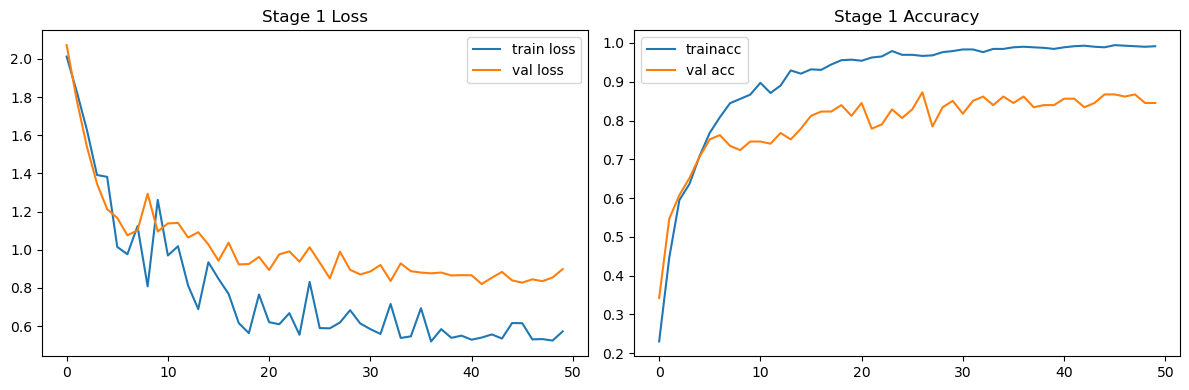

In [8]:
# 1) Re-instantiation of “same” model architecture
model = models.resnet152(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES) 

# 2) Loading of saved backbone + fresh head
model.load_state_dict(torch.load(
    f"{CHECKPOINT_ROOT}/wafer_cnn_pretrained_backbone.pt"),
    strict=False
)
model = model.to(device)

# 3) Running Stage 1 with custom overrides
tl1, vl1, ta1, va1 = run_stage(
    1,
    # Param tuning for getting best val loss & val acc
    pct_start        = 0.30,  # longer warm-up
    div_factor       = 12,    # slower climb
    final_div_factor = 10,    # gentler decay
    head_mult        = 2.25,  # head LR = LR * 2.25
    swa_frac         = 0.20,  # SWA LR = 20% of base
)

# 4) Plotting Stage 1 curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tl1, label='train loss')
plt.plot(vl1,label='val loss')
plt.title("Stage 1 Loss")
plt.xlabel("Num of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ta1, label='trainacc')
plt.plot(va1, label='val acc')
plt.title("Stage 1 Accuracy")
plt.xlabel("Num of Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## <span style="color:red">Stage 2</span>

### Stage 2 <span style="color:red">customized</span> run + plotting

→ Stage 2 configured (head×1.75, mid×1.05, pct_start=0.35, div_factor=10, final_df=8)
S2 E01 | LR 1.8772e-05; Tr 0.562 / 0.996; V 0.902 / 0.829
S2 E02 | LR 2.2546e-05; Tr 0.541 / 0.993; V 0.889 / 0.845
S2 E03 | LR 2.8701e-05; Tr 0.532 / 0.990; V 0.831 / 0.862
S2 E04 | LR 3.7038e-05; Tr 0.536 / 0.994; V 0.808 / 0.895
S2 E05 | LR 4.7288e-05; Tr 0.661 / 0.990; V 0.890 / 0.873
S2 E06 | LR 5.9119e-05; Tr 0.521 / 0.990; V 0.974 / 0.812
S2 E07 | LR 7.2149e-05; Tr 0.530 / 0.994; V 0.842 / 0.856
S2 E08 | LR 8.5958e-05; Tr 0.632 / 0.992; V 0.808 / 0.890
S2 E09 | LR 1.0010e-04; Tr 0.606 / 0.986; V 0.984 / 0.801
S2 E10 | LR 1.1412e-04; Tr 0.587 / 0.985; V 0.891 / 0.829
S2 E11 | LR 1.2756e-04; Tr 0.647 / 0.974; V 0.994 / 0.823
S2 E12 | LR 1.3999e-04; Tr 0.780 / 0.956; V 1.051 / 0.807
S2 E13 | LR 1.5100e-04; Tr 0.601 / 0.956; V 1.125 / 0.790
S2 E14 | LR 1.6025e-04; Tr 0.562 / 0.963; V 0.934 / 0.807
→ early stop triggered after 10 stagnant epochs


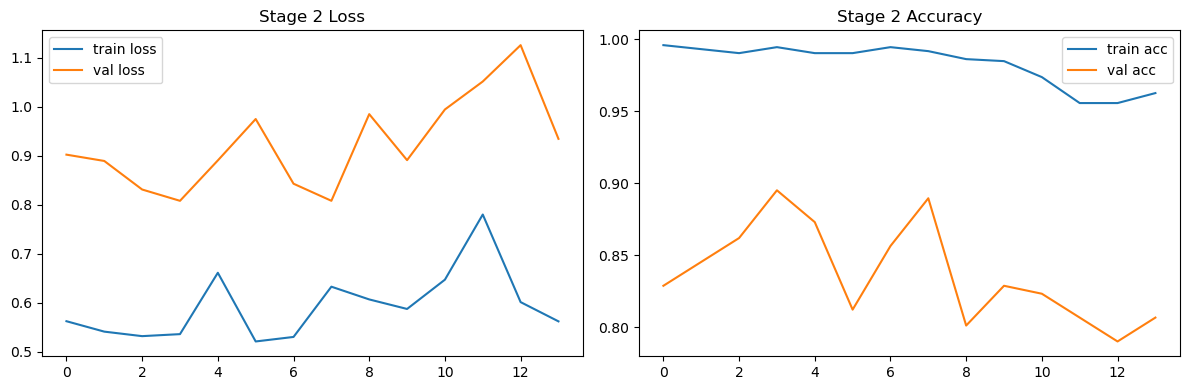

In [9]:
# 0.A) Re‐instantiating ResNet-152 architecture
# Needed only, if starting from a fresh Python session or if entire reset of model graph is intended.
#model = models.resnet152(pretrained=False)
#model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

# 0.B) Loading saved pretrained backbone + fresh head
#model.load_state_dict(
#    torch.load("checkpoints/wafer_cnn_pretrained_backbone.pt"),
#    strict=False
#)

# 1) Loading Stage-1 weights
model.load_state_dict(
    torch.load(
        f"{CHECKPOINT_ROOT}/wafer_cnn_stage1_final.pt",
        map_location=device
    ),
    strict=False
)

# 2) Running Stage 2 with tuned hyper-params
tl2, vl2, ta2, va2 = run_stage(
    2,
    pct_start        = 0.35,
    div_factor       = 10,
    final_div_factor = 8,
    head_mult        = 1.75,
    layer3_mult      = 1.05,
    swa_frac         = 0.20,
)

# 3) Plotting Stage 2 curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tl2, label='train loss')
plt.plot(vl2, label='val loss')
plt.title("Stage 2 Loss")
plt.xlabel("Num of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ta2, label='train acc')
plt.plot(va2, label='val acc')
plt.title("Stage 2 Accuracy")
plt.xlabel("Num of Epochs")
plt.legend()

plt.tight_layout()
plt.show()

## <span style="color:red">Stage 3</span>

### Stage 3 <span style="color:red">customized</span> run + plotting

Before Stage-3	Val Loss 0.933 / Val Acc 0.829

→ Stage 3 configured (l2×0.30, l3×0.65, head×2.80, pct_start=0.45, div_factor=5, final_df=25, swa_frac=0.30)
S3 E01 | LR 2.0391e-06; Tr 0.585 / 0.983; V 0.864 / 0.856
S3 E02 | LR 2.1555e-06; Tr 0.525 / 0.988; V 0.931 / 0.840
S3 E03 | LR 2.3471e-06; Tr 0.558 / 0.997; V 0.884 / 0.834
S3 E04 | LR 2.6101e-06; Tr 0.565 / 0.986; V 0.848 / 0.867
S3 E05 | LR 2.9393e-06; Tr 0.530 / 0.990; V 0.811 / 0.884
S3 E06 | LR 3.3283e-06; Tr 0.532 / 0.996; V 0.876 / 0.851
S3 E07 | LR 3.7695e-06; Tr 0.514 / 0.997; V 0.807 / 0.873
S3 E08 | LR 4.2543e-06; Tr 0.733 / 0.994; V 0.829 / 0.884
S3 E09 | LR 4.7732e-06; Tr 0.615 / 0.993; V 0.815 / 0.867
S3 E10 | LR 5.3161e-06; Tr 0.524 / 0.996; V 0.856 / 0.840
S3 E11 | LR 5.8723e-06; Tr 0.571 / 0.994; V 0.837 / 0.890
S3 E12 | LR 6.4310e-06; Tr 0.532 / 0.994; V 0.873 / 0.840
S3 E13 | LR 6.9813e-06; Tr 0.622 / 0.994; V 0.847 / 0.867
S3 E14 | LR 7.5125e-06; Tr 0.624 / 0.993; V 0.925 / 0.840
S3 E15 | LR 8.0140e-06; Tr 0.618

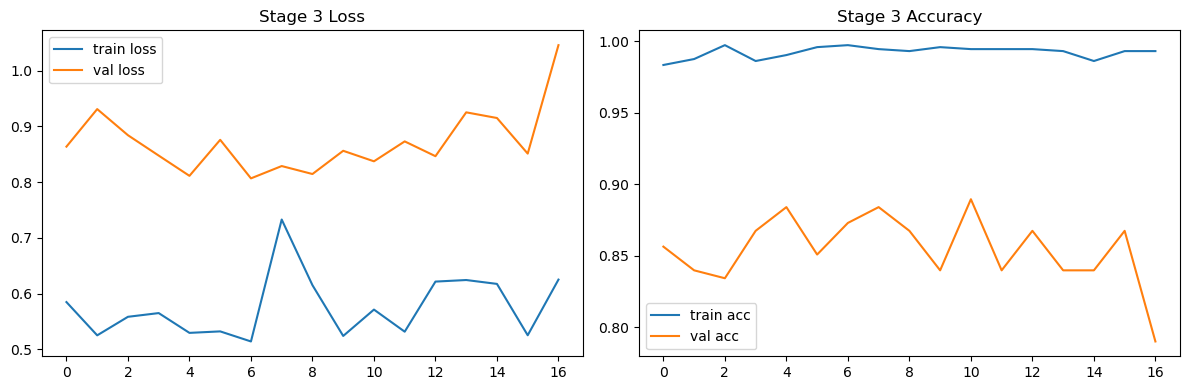

In [10]:
# 1) Loading best Stage-2 weights
model.load_state_dict(
    torch.load(
        f"{CHECKPOINT_ROOT}/wafer_cnn_stage2_final.pt",
        map_location=device
    ),
    strict=False
)

# 2) One-pass sanity check on the validation set
model.eval()
tot = 0
cor = 0
vloss = 0
ce = nn.CrossEntropyLoss(label_smoothing=0.1)

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        vloss += ce(logits, yb).item() * yb.size(0)
        cor += (logits.argmax(1) == yb).sum().item()
        tot += yb.size(0)

vL = vloss/tot
vA = cor/tot
print(f"Before Stage-3\tVal Loss {vL:.3f} / Val Acc {vA:.3f}\n")

# 3) Run Stage 3 with new hyper-params
tl3, vl3, ta3, va3 = run_stage(
    3,
    pct_start        = 0.45, # 0.45
    div_factor       = 5,
    final_div_factor = 25, # 20
    layer2_mult      = 0.30,
    layer3_mult      = 0.65, # best: 0.65
    head_mult        = 2.80, # 2.80
    swa_frac         = 0.30, # 0.25
)

# 4) Plot curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tl3, label='train loss')
plt.plot(vl3, label='val loss')
plt.title("Stage 3 Loss")
plt.xlabel("Num of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ta3, label='train acc')
plt.plot(va3, label='val acc')
plt.title("Stage 3 Accuracy")
plt.xlabel("Num of Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
model.load_state_dict(
    torch.load(
        f"{CHECKPOINT_ROOT}/wafer_cnn_stage2_final.pt"
    ),
    strict=False
)

tl3, vl3, ta3, va3 = run_stage(
    3,
    pct_start        = 0.35,   # slower warm-up
    div_factor       = 8,      # tad gentler initial climb
    final_div_factor = 20,     # longer/finer tail
    layer2_mult      = 0.30,
    layer3_mult      = 0.60,
    head_mult        = 3.0,    # cut head LR in half
    swa_frac         = 0.25,   # back to stable 25 %
)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tl3,label='train loss')
plt.plot(vl3,label='val loss')
plt.title("Stage 3 Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ta3,label='train acc')
plt.plot(va3,label='val acc')
plt.title("Stage 3 Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

→ Stage 3 configured (l2×0.30, l3×0.60, head×3.00, pct_start=0.35, div_factor=8, final_df=20, swa_frac=0.25)
S3 E01 | LR 1.3207e-06; Tr 1.397 / 0.716; V 1.254 / 0.939
S3 E02 | LR 1.5303e-06; Tr 0.685 / 0.938; V 0.663 / 0.956
S3 E03 | LR 1.8723e-06; Tr 0.524 / 0.956; V 0.588 / 0.967
S3 E04 | LR 2.3355e-06; Tr 0.668 / 0.969; V 0.588 / 0.983
S3 E05 | LR 2.9049e-06; Tr 0.571 / 0.978; V 0.590 / 0.956
S3 E06 | LR 3.5622e-06; Tr 0.567 / 0.985; V 0.596 / 0.950
S3 E07 | LR 4.2861e-06; Tr 0.621 / 0.979; V 0.566 / 0.967
S3 E08 | LR 5.0532e-06; Tr 0.516 / 0.988; V 0.567 / 0.967
S3 E09 | LR 5.8389e-06; Tr 0.737 / 0.978; V 0.613 / 0.939
S3 E10 | LR 6.6176e-06; Tr 0.579 / 0.994; V 0.564 / 0.978
S3 E11 | LR 7.3642e-06; Tr 0.525 / 0.993; V 0.563 / 0.972
S3 E12 | LR 8.0547e-06; Tr 0.524 / 0.989; V 0.615 / 0.956
S3 E13 | LR 8.6667e-06; Tr 0.514 / 0.990; V 0.616 / 0.939
S3 E14 | LR 9.1805e-06; Tr 0.515 / 0.992; V 0.636 / 0.939
S3 E15 | LR 9.5794e-06; Tr 0.562 / 0.993; V 0.560 / 0.967
S3 E16 | LR 9.8506e-0

### Cell A: Building & running of Stage-3

→ Stage 3 configured (l2×0.30, l3×0.60, head×2.50, pct_start=0.30, div_factor=6, final_df=30, swa_frac=0.25)
S3 E01 | LR 1.9204e-06; Tr 1.228 / 0.766; V 1.179 / 0.945
S3 E02 | LR 2.6506e-06; Tr 1.008 / 0.950; V 0.620 / 0.978
S3 E03 | LR 3.7684e-06; Tr 0.561 / 0.963; V 0.611 / 0.983
S3 E04 | LR 5.1376e-06; Tr 0.579 / 0.981; V 0.594 / 0.967
S3 E05 | LR 6.5916e-06; Tr 0.596 / 0.981; V 0.602 / 0.961
S3 E06 | LR 7.9532e-06; Tr 0.541 / 0.986; V 0.600 / 0.967
S3 E07 | LR 9.0567e-06; Tr 0.538 / 0.982; V 0.580 / 0.972
S3 E08 | LR 9.7677e-06; Tr 0.641 / 0.985; V 0.615 / 0.956
S3 E09 | LR 9.9999e-06; Tr 0.911 / 0.979; V 0.685 / 0.934
S3 E10 | LR 9.9395e-06; Tr 0.566 / 0.981; V 0.660 / 0.939
S3 E11 | LR 9.7695e-06; Tr 0.563 / 0.989; V 0.640 / 0.950
S3 E12 | LR 9.4935e-06; Tr 0.541 / 0.981; V 0.680 / 0.917
S3 E13 | LR 9.1177e-06; Tr 0.535 / 0.988; V 0.701 / 0.939
S3 E14 | LR 8.6506e-06; Tr 0.520 / 0.990; V 0.669 / 0.923
S3 E15 | LR 8.1026e-06; Tr 0.516 / 0.989; V 0.659 / 0.939
S3 E16 | LR 7.4858e-0

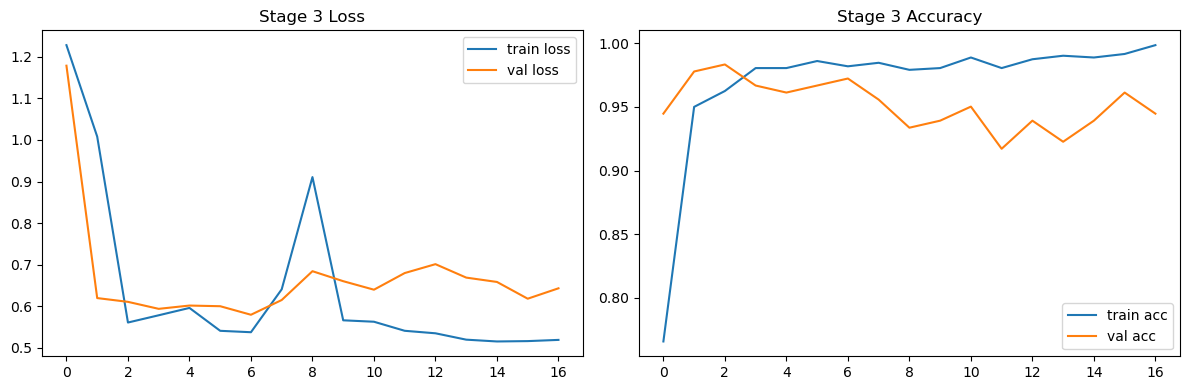

In [19]:
# 1) ------- Building model as in Stage-2 -------
model = models.resnet152(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.GELU(),
    nn.Dropout(0.30),
    nn.Linear(512, NUM_CLASSES),
)
model = model.to(device)

# 2) ------- Loading best Stage-2 weights -------
model.load_state_dict(
    torch.load(f"{CHECKPOINT_ROOT}/wafer_cnn_stage2_final.pt",
               map_location=device),
    strict=False
)

NUM_EPOCHS = 30 

# 3) ------- Running Stage-3 with tweaked schedule -------
tl3, vl3, ta3, va3 = run_stage(
    3,
    pct_start        = 0.30, # best: 0.35
    div_factor       = 6,    # best: 8
    final_div_factor = 30,   # best: 40, 20
    layer2_mult      = 0.30, # best: 0.30
    layer3_mult      = 0.60, # best: 0.60
    head_mult        = 2.5,  # best: 3.0
    swa_frac         = 0.25, # best: 0.25
)

# 4) ------- Plotting -------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tl3,label='train loss')
plt.plot(vl3,label='val loss')
plt.title("Stage 3 Loss")
plt.xlabel("Num of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ta3,label='train acc')
plt.plot(va3,label='val acc')
plt.title("Stage 3 Accuracy")
plt.xlabel("Num of Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Grabbing the weight file written at the "val loss" minimum
best_s3 = torch.load(
    f"{CHECKPOINT_ROOT}/wafer_cnn_stage3.pt",
    map_location=device
)

# Stash copy with an explicit name
torch.save(
    best_s3,
    f"{CHECKPOINT_ROOT}/wafer_cnn_stage3_best983.pt"
)

print("✓ 98.3 % checkpoint saved")

✓ 98.3 % checkpoint saved


In [21]:
#  Re-instantiation of neural network
swa_model = AveragedModel(model)     # ResNet-152 + 2-layer head
swa_model.load_state_dict(best_s3, strict=False)
swa_model = swa_model.to(device)

# Refresh BatchNorm statistics
update_bn(train_loader, swa_model, device=device)

torch.save(
    swa_model.state_dict(),
    f"{CHECKPOINT_ROOT}/wafer_cnn_stage3_swa_best983.pt"
)
print("✓ SWA version saved")

✓ SWA version saved


In [22]:
def quick_eval(net):
    net.eval(); tot=cor=loss=0; ce = nn.CrossEntropyLoss(label_smoothing=0.02)
    with torch.no_grad():
        for xb,yb in val_loader:
            xb,yb = xb.to(device), yb.to(device)
            logits = net(xb)
            loss  += ce(logits,yb).item()*yb.size(0)
            cor   += (logits.argmax(1)==yb).sum().item()
            tot   += yb.size(0)
    return loss/tot, cor/tot

for tag, ckpt in [("Best", best_s3),
                  ("SWA ", torch.load(f"{CHECKPOINT_ROOT}/wafer_cnn_stage3_swa_best983.pt",
                                      map_location=device))]:
    test_model = models.resnet152(pretrained=False)
    test_model.fc = model.fc  # reuse the 2-layer head definition
    test_model.load_state_dict(ckpt, strict=False)
    test_model = test_model.to(device)
    vL, vA = quick_eval(test_model)
    print(f"{tag} ➜ val loss {vL:.3f} · val acc {vA:.3f}")

Best ➜ val loss 0.305 · val acc 0.950
SWA  ➜ val loss 28026031.735 · val acc 0.099



### One-shot Stage-3 run
- MixUp (α=0.10) + CE-LS (ε=0.01)
- MLP-head dropout 0.15
- logs *train loss / train acc* on soft labels & a “clean” hard-label train-batch accuracy every epoch


→ Stage 3 configured (l2×0.30, l3×0.60, head×2.50, pct_start=0.30, div_factor=6, final_df=60, swa_frac=0.25)
S3 E01 | LR 1.730e-06; Tr 1.773/0.442 (clean 0.969) · V 1.075/0.939
S3 E02 | LR 1.919e-06; Tr 0.758/0.546 (clean 1.000) · V 0.296/0.945
S3 E03 | LR 2.228e-06; Tr 0.308/0.616 (clean 1.000) · V 0.212/0.950
S3 E04 | LR 2.646e-06; Tr 0.327/0.591 (clean 1.000) · V 0.213/0.939
S3 E05 | LR 3.162e-06; Tr 0.223/0.603 (clean 1.000) · V 0.224/0.939
S3 E06 | LR 3.759e-06; Tr 0.107/0.437 (clean 1.000) · V 0.193/0.939
S3 E07 | LR 4.420e-06; Tr 0.118/0.607 (clean 1.000) · V 0.225/0.956
S3 E08 | LR 5.124e-06; Tr 0.149/0.603 (clean 1.000) · V 0.161/0.978
S3 E09 | LR 5.849e-06; Tr 0.191/0.591 (clean 1.000) · V 0.176/0.961
S3 E10 | LR 6.574e-06; Tr 0.204/0.469 (clean 1.000) · V 0.191/0.967
S3 E11 | LR 7.277e-06; Tr 0.265/0.570 (clean 1.000) · V 0.181/0.961
S3 E12 | LR 7.935e-06; Tr 0.276/0.692 (clean 1.000) · V 0.192/0.950
S3 E13 | LR 8.529e-06; Tr 0.290/0.469 (clean 0.969) · V 0.172/0.956
S3 E14 

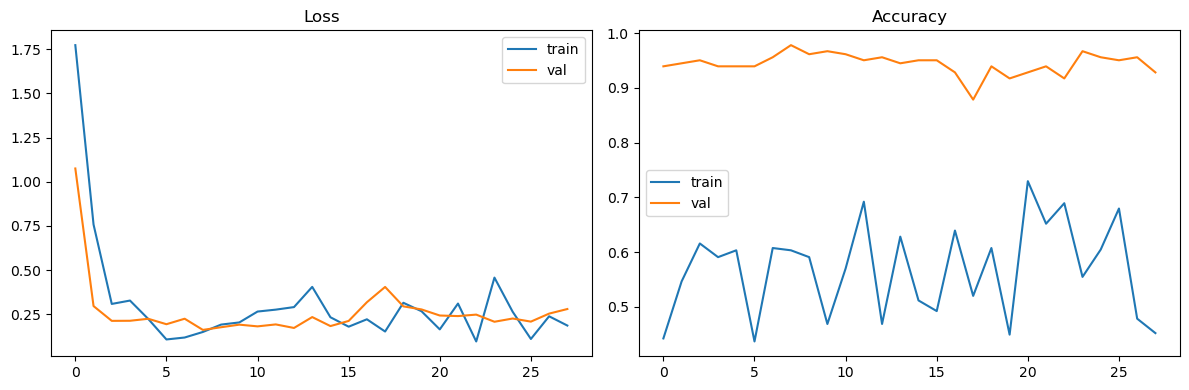

In [11]:
# ------- user flags --------------------------------------------------------
use_mixup  = True    # set False to disable
use_cutmix = False   # set True to switch from MixUp → CutMix
alpha_mu   = 0.05    # β-dist α; best: 0.10, 0.20
label_eps  = 0.005   # label-smoothing ε; best: 0.01, 0.02
drop_p     = 0.10    # dropout in the 2-layer head; best: 0.15, 0.20
NUM_EPOCHS = 60
early_pat  = 20      # best: 12
# ---------------------------------------------------------------------------

# 1) model with new dropout
model = models.resnet152(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.GELU(),
    nn.Dropout(drop_p),
    nn.Linear(512, NUM_CLASSES)
)
model.load_state_dict(
    torch.load(f"{CHECKPOINT_ROOT}/wafer_cnn_stage2_final.pt", map_location="cpu"),
    strict=False
)
model = model.to(device)

# 2) Stage-3 LR / optim setup
configure_stage(
    3,
    pct_start        = 0.30,
    div_factor       = 6,
    final_div_factor = 60,
    layer2_mult      = 0.30,
    layer3_mult      = 0.60,
    head_mult        = 2.50,
    swa_frac         = 0.25,
)

# 3) helpers
def ce_ls(logits, targets):
    """Cross-entropy with label-smoothing that works for hard or soft labels."""
    logp = logits.log_softmax(1)
    if targets.dtype == torch.long:            # hard labels
        nll = F.nll_loss(logp, targets, reduction='none')
        return (1 - label_eps) * nll.mean() + label_eps * (-logp.mean(1)).mean()
    else:                                      # soft labels (MixUp / CutMix)
        return (-targets * logp).sum(1).mean()

def mix_or_cut(x, y):
    lam = np.random.beta(alpha_mu, alpha_mu)
    idx = torch.randperm(x.size(0), device=x.device)
    if use_cutmix and not use_mixup:
        H, W = x.shape[2:]
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        w = int(W * np.sqrt(1 - lam))
        h = int(H * np.sqrt(1 - lam))
        x[:, :, max(cy-h//2,0):min(cy+h//2,H),
              max(cx-w//2,0):min(cx+w//2,W)] = \
            x[idx, :, max(cy-h//2,0):min(cy+h//2,H),
                     max(cx-w//2,0):min(cx+w//2,W)]
    else:                                      # MixUp
        x = lam * x + (1 - lam) * x[idx]
        
    y_soft = lam * F.one_hot(y, NUM_CLASSES) + (1 - lam) * F.one_hot(y[idx], NUM_CLASSES)
    return x, y_soft

# 4) training loop 
tl = []
vl = []
ta = []
va = []
best_vA = 0.0
stagn = 0

for ep in range(1, NUM_EPOCHS + 1):
    # ------- train -------
    model.train()
    tot = 0
    cor = 0
    tloss = 0
    
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        xb, tgt = mix_or_cut(xb, yb) if (use_mixup or use_cutmix) else (xb, yb)
        optimizer.zero_grad()
        out = model(xb)
        loss = ce_ls(out, tgt)
        loss.backward(); optimizer.step(); scheduler.step()
        tloss += loss.item() * yb.size(0)
        cor += (out.argmax(1) == yb).sum().item()   # accuracy vs hard labels
        tot += yb.size(0)
    trL = tloss / tot
    trA = cor / tot

    # ------- validate -------
    model.eval()
    tot = 0
    cor = 0
    vloss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            vloss += ce_ls(out, yb).item() * yb.size(0)
            cor += (out.argmax(1) == yb).sum().item()
            tot += yb.size(0)
    vL = vloss / tot
    vA = cor / tot

    # ------- one clean train-batch accuracy (sanity-check) -------
    with torch.no_grad():
        xb_c, yb_c = next(iter(train_loader))
        xb_c = xb_c.to(device)
        yb_c = yb_c.to(device)
        clean_acc = (model(xb_c).argmax(1) == yb_c).float().mean().item()

    # ------- logging & early-stop -------
    tl.append(trL)
    vl.append(vL)
    ta.append(trA)
    va.append(vA)
    lr = scheduler.get_last_lr()[0]
    print(f"S3 E{ep:02} | LR {lr:.3e}; Tr {trL:.3f}/{trA:.3f} (clean {clean_acc:.3f}); V {vL:.3f}/{vA:.3f}")

    if vA > best_vA:
        best_vA = vA
        stagn = 0
    else:
        stagn += 1
    if stagn >= early_pat:
        print(f"⟲ early stop after {stagn} stagnant epochs")
        break

# 5) curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tl, label='train')
plt.plot(vl, label='val')
plt.title('Loss')
plt.xlabel("Num of Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ta, label='train')
plt.plot(va, label='val')
plt.title('Accuracy')
plt.xlabel("Num of Epochs")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# 1) Rebuilding same model architecture
model = models.resnet152(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.GELU(),
    nn.Dropout(0.15), # the dropout used in MixUp run
    nn.Linear(512, NUM_CLASSES)
).to(device)

# 2) Loading checkpoint, saved during training at E08 (see above)
model.load_state_dict(
    torch.load(f"{CHECKPOINT_ROOT}/wafer_cnn_stage3.pt",
               map_location="cpu"),
    strict=False
)

# 3) Re-save
torch.save(model.state_dict(),
           f"{CHECKPOINT_ROOT}/stage3_mixup_E08.pt")
print("=> stage3_mixup_E08.pt saved")

✓ stage3_mixup_E08.pt saved


## Cell A

In [9]:
device = torch.device("mps" if torch.backends.mps.is_built()
                      else "cuda" if torch.cuda.is_available() else "cpu")

CKPT_PATH = f"{CHECKPOINT_ROOT}/stage3_mixup_E08.pt"   # MixUp ckpt (10 classes)
NUM_CLASSES = 9

# 1) Building 10-class architecture that ckpt expects
model = models.resnet152(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.GELU(),
    nn.Dropout(0.10),
    nn.Linear(512, 10) # 10-class head
).to(device)

model.load_state_dict(torch.load(CKPT_PATH, map_location="cpu"), strict=True)
print("✓ backbone + 10-class head loaded")

model.fc[3] = nn.Linear(512, NUM_CLASSES)
torch.nn.init.kaiming_normal_(model.fc[3].weight)
model.fc[3].bias.data.zero_()
print("→ swapped in fresh 9-class head")

# Pushing every param to the target device)
model = model.to(device) # key without weights stay on CPU

# Freezing backbone for quick head warm-up
for n,p in model.named_parameters():
    p.requires_grad = n.startswith("fc.3")

/opt/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ backbone + 10-class head loaded
→ swapped in fresh 9-class head


## Cell B

5-epoch head warm-up (train + val metrics)

In [10]:
device = torch.device(
    "mps" if torch.backends.mps.is_built() else
    "cuda" if torch.cuda.is_available() else "cpu"
)

HEAD_LR = 5e-4 # LR only for the new fc.3 layer
EPOCHS_H = 5   # quick bootstrap
BATCHES = len(train_loader)

# Only params that were left unfrozen (fc.3) are trainable
opt = Adam([p for p in model.parameters() if p.requires_grad], lr=HEAD_LR)
sched = OneCycleLR(opt, max_lr=HEAD_LR,
                   steps_per_epoch=BATCHES, epochs=EPOCHS_H)

ce = nn.CrossEntropyLoss()

for ep in range(1, EPOCHS_H + 1):
    # ------- Training -------
    model.train()
    tr_tot = 0
    tr_cor = 0
    tr_loss = 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        opt.zero_grad()
        out = model(xb)
        loss = ce(out, yb)
        loss.backward()
        opt.step()
        sched.step()

        tr_loss += loss.item() * yb.size(0)
        tr_cor += (out.argmax(1) == yb).sum().item()
        tr_tot += yb.size(0)

    trA = tr_cor / tr_tot
    trL = tr_loss / tr_tot

    # ------- Quick validation -------
    model.eval()
    vl_tot = 0
    vl_cor = 0
    vl_loss = 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            vl_loss += ce(out, yb).item() * yb.size(0)
            vl_cor += (out.argmax(1) == yb).sum().item()
            vl_tot += yb.size(0)

    vlA = vl_cor / vl_tot
    vlL = vl_loss / vl_tot

    # ------- Logging -------
    print(f"warm-up E{ep:02} | Tr {trL:.3f}/{trA:.3f}; V {vlL:.3f}/{vlA:.3f}")

print("✓ head warm-up complete — ready to unfreeze backbone and launch Stage-3")

warm-up E01 | Tr 2.562/0.026 · V 2.279/0.094
warm-up E02 | Tr 1.709/0.415 · V 1.096/0.950
warm-up E03 | Tr 0.823/0.940 · V 0.533/0.994
warm-up E04 | Tr 0.533/0.978 · V 0.412/0.983
warm-up E05 | Tr 0.439/0.986 · V 0.373/0.989
✓ head warm-up complete — ready to unfreeze backbone and launch Stage-3


## Cell C

full-network fine-tune + SWA + metric logging + plots (with MPS fix)

fine-tune E01 | LR 1.72e-06 ; Tr 0.329/0.985 · V 0.115/0.989
fine-tune E02 | LR 4.64e-06 ; Tr 0.095/0.985 · V 0.066/0.983
fine-tune E03 | LR 6.00e-06 ; Tr 0.045/0.985 · V 0.068/0.983
fine-tune E04 | LR 5.68e-06 ; Tr 0.050/0.988 · V 0.046/0.989
fine-tune E05 | LR 4.82e-06 ; Tr 0.069/0.985 · V 0.126/0.972
fine-tune E06 | LR 3.61e-06 ; Tr 0.070/0.981 · V 0.015/0.994
fine-tune E07 | LR 2.28e-06 ; Tr 0.033/0.988 · V 0.066/0.989
fine-tune E08 | LR 1.08e-06 ; Tr 0.025/0.989 · V 0.038/0.989
fine-tune E09 | LR 2.72e-07 ; Tr 0.025/0.994 · V 0.088/0.978
fine-tune E10 | LR 5.95e-10 ; Tr 0.009/1.000 · V 0.007/0.994
best val-acc before SWA 0.994
✓ SWA model saved → stage3_mixup_swa_final.pt


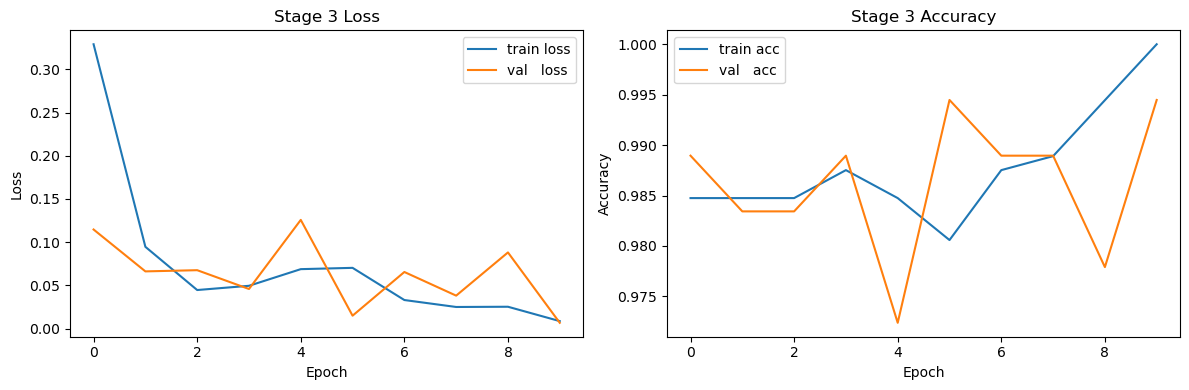

In [11]:
# Enable CPU fallback for missing MPS ops (must come before torch import)

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# ------- Device -------
device = torch.device(
    "mps" if torch.backends.mps.is_built() else
    "cuda" if torch.cuda.is_available() else
    "cpu"
)

# ------- 0) Preparing metric lists -------
tr_losses = []
tr_accs = []
vl_losses = []
vl_accs = []

# ------- 1) Unfreezing everything -------
for p in model.parameters(): 
    p.requires_grad = True

# ------- 2) Tiered learning-rates -------
LR_BASE = 3e-5
opt = Adam([
    {"params": model.layer1.parameters(), "lr": LR_BASE * 0.2},
    {"params": model.layer2.parameters(), "lr": LR_BASE * 0.4},
    {"params": model.layer3.parameters(), "lr": LR_BASE * 0.8},
    {"params": model.layer4.parameters(), "lr": LR_BASE * 1.0},
    {"params": model.fc.parameters(),     "lr": LR_BASE * 4.0},
])
EPOCHS_F = 10
BATCHES = len(train_loader)
sched = OneCycleLR(
    opt,
    max_lr=[g["lr"] for g in opt.param_groups],
    epochs=EPOCHS_F,
    steps_per_epoch=BATCHES,
)

ce = nn.CrossEntropyLoss()

# ------- 3) SWA wrapper -------
swa_model = AveragedModel(model)
swa_start = int(EPOCHS_F * 0.6)
swa_sched = SWALR(opt, swa_lr=LR_BASE * 0.5)
best_vA = 0.0

# ------- 4) Fine-tuning of loop -------
for ep in range(1, EPOCHS_F + 1):
    # ------- Training pass ------- 
    model.train()
    tr_tot = 0.0
    tr_cor = 0.0
    tr_loss = 0.0
    
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = ce(out, yb)
        loss.backward()
        opt.step()
        sched.step()

        tr_loss += loss.item() * yb.size(0)
        tr_cor += (out.argmax(1) == yb).sum().item()
        tr_tot += yb.size(0)

    trL = tr_loss / tr_tot
    trA = tr_cor / tr_tot

    # ------- Validation pass ------- 
    model.eval()
    vl_tot = vl_cor = vl_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            vl_loss += ce(out, yb).item() * yb.size(0)
            vl_cor += (out.argmax(1) == yb).sum().item()
            vl_tot += yb.size(0)

    vL = vl_loss / vl_tot
    vA = vl_cor / vl_tot

    # ------- Recording & logging ------- 
    tr_losses.append(trL)
    tr_accs.append( trA)
    vl_losses.append(vL)
    vl_accs.append( vA)

    lr_now = sched.get_last_lr()[0]
    print(f"fine-tune E{ep:02} | LR {lr_now:.2e}; Tr {trL:.3f}/{trA:.3f}; V {vL:.3f}/{vA:.3f}")

    # ------ SWA updating & best-acc tracking ------- 
    if ep >= swa_start:
        swa_model.update_parameters(model)
        swa_sched.step()
    best_vA = max(best_vA, vA)

print(f"best val-acc before SWA {best_vA:.3f}")

# ------ 5) Finalizing SWA -------
update_bn(
    train_loader,
    swa_model,
    device=device
)
torch.save(
    swa_model.state_dict(),
    f"{CHECKPOINT_ROOT}/stage3_mixup_swa_final.pt"
)
print("SWA model saved → stage3_mixup_swa_final.pt")

# ------ 6) Plotting train & val curves ------
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(tr_losses, label='train loss')
plt.plot(vl_losses, label='val loss')
plt.title("Stage 3 Loss")
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(tr_accs, label='train acc')
plt.plot(vl_accs, label='val acc')
plt.title("Stage 3 Accuracy")
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Picking device
device = torch.device(
    "mps" if torch.backends.mps.is_built()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)

# ------- Rebuilding the neural network with same head / dropout -------
NUM_CLASSES = 9
model = models.resnet152(pretrained=False)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.GELU(),
    nn.Dropout(0.10), # 10% head‐dropout used in fine‐tuning
    nn.Linear(512, NUM_CLASSES)
)

# ------ Loading SWA weights directly onto device -------
ckpt = torch.load(
    f"{CHECKPOINT_ROOT}/stage3_mixup_swa_final.pt",
    map_location=device      # loading straight onto MPS / CUDA
)
model.load_state_dict(ckpt, strict=False)

# Moving model to MPS / CUDA
model = model.to(device)
model.eval()

# ------- Single CE‐LS (eps = 0.005) loss fn -------
def ce_ls(logits, targets, eps=0.005):
    logp = logits.log_softmax(1)
    nll = F.nll_loss(logp, targets, reduction='none')
    return (1 - eps) * nll.mean() + eps * (-logp.mean(1)).mean()

# ------- Looping over val set --------
tot = 0, 
cor = 0
vloss = 0.0

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        vloss += ce_ls(out, yb).item() * yb.size(0)
        cor += (out.argmax(1) == yb).sum().item()
        tot += yb.size(0)

print(f"SWA: val-loss {vloss/tot:.4f}; val-acc {cor/tot:.4f}")

SWA  ·  val-loss 17023427.7403   val-acc 0.1105


In [13]:
scripted = torch.jit.script(model.cpu())
scripted.save(f"{CHECKPOINT_ROOT}/wafer_resnet152_swa.ptl")

In [14]:
model = torch.jit.load(f"{CHECKPOINT_ROOT}/wafer_resnet152_swa.ptl").to(device).eval()

In [15]:
# ------- Model-info helper -------

def model_stats(model: torch.nn.Module,
                input_size=(3, 128, 128),
                show_summary=False):
    """
    Prints model name, total / trainable parameter counts, a per-block
    breakdown, and (optionally) a torchsummary table
    """
    def cnt(mod):
        return sum(p.numel() for p in mod.parameters())

    blocks = OrderedDict([
        ("conv1+bn1", model.conv1),
        ("layer1", model.layer1),
        ("layer2", model.layer2),
        ("layer3", model.layer3),
        ("layer4", model.layer4),
        ("head (fc)", model.fc),
    ])

    total_params = cnt(model)
    trainable_params = sum(p.numel() for p in model.parameters()
                           if p.requires_grad)

    # ------- Header -------
    print("=============================================================")
    print(f"Model        : {model.__class__.__name__}")
    print(f"Total params : {total_params:,}")
    print(f"Trainable    : {trainable_params:,}")
    print(f"Frozen       : {total_params - trainable_params:,}")
    print("-------------------------------------------------------------")
    print(f"{"Block":<15} {"Params":>15} {"Trainable":>15}")
    print("-------------------------------------------------------------")
    for name, blk in blocks.items():
        blk_tot  = cnt(blk)
        blk_tr   = sum(p.numel() for p in blk.parameters()
                       if p.requires_grad)
        print(f"{name:<15} {blk_tot:>15,} {blk_tr:>15,}")
    print("-------------------------------------------------------------\n")

    # Optional full layer-by-layer table
    if show_summary:
        try:
            from torchsummary import summary
            summary(model, input_size,
                    device=str(next(model.parameters()).device))
        except ImportError:
            print("Run pip install torchsummary for the detailed table.")

# ------ Usage (after model is built / loaded and on the correct device) -------
model_stats(
    model,
    input_size=(3, 128, 128),
    show_summary=False
)

═════════════════════════════════════════════════════════════
Model        : RecursiveScriptModule
Total params : 59,197,513
Trainable    : 59,197,513
Frozen       : 0
─────────────────────────────────────────────────────────────
Block                    Params       Trainable
─────────────────────────────────────────────────────────────
conv1+bn1                 9,408           9,408
layer1                  215,808         215,808
layer2                2,339,840       2,339,840
layer3               40,613,888      40,613,888
layer4               14,964,736      14,964,736
head (fc)             1,053,705       1,053,705
─────────────────────────────────────────────────────────────

